In [444]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Lendo imagens

In [445]:
baboon_p = cv2.imread('baboon_perspectiva.png', cv2.IMREAD_GRAYSCALE)
tom = cv2.imread('tom_platz.jpeg', cv2.IMREAD_COLOR)[:,:,::-1]
babs = cv2.imread('baboon.png', cv2.IMREAD_GRAYSCALE)

### Projeção Perspectiva

Matriz e Aplicação


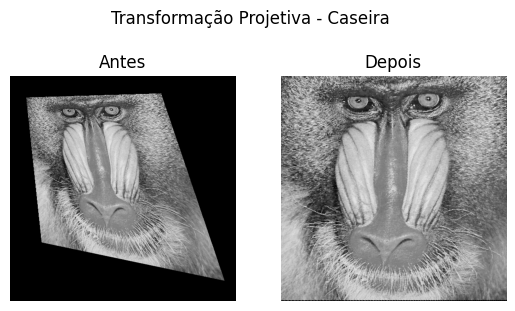

In [446]:
og_points = np.array([[37,51], [342, 42], [485, 467], [73, 380]], dtype=np.float32)
new_points = np.array([[0, 0], [511, 0], [511, 511], [0, 511]], dtype=np.float32)

'''
*             a                         x    b
* | x0 y0  1  0  0  0 -x0*u0 -y0*u0 | |c00| |u0|
* | x1 y1  1  0  0  0 -x1*u1 -y1*u1 | |c01| |u1|
* | x2 y2  1  0  0  0 -x2*u2 -y2*u2 | |c02| |u2|
* | x3 y3  1  0  0  0 -x3*u3 -y3*u3 |.|c10|=|u3|,
* |  0  0  0 x0 y0  1 -x0*v0 -y0*v0 | |c11| |v0|
* |  0  0  0 x1 y1  1 -x1*v1 -y1*v1 | |c12| |v1|
* |  0  0  0 x2 y2  1 -x2*v2 -y2*v2 | |c20| |v2|
* |  0  0  0 x3 y3  1 -x3*v3 -y3*v3 | |c21| |v3|
'''

def get_matrix_perspectiva(src_points, new_points):  
    # mounting new coef matrix
	coef_m = np.zeros((8,6))
	coef_m[:4, :2] = src_points
	coef_m[:4, 2] = 1
	coef_m[4:, 5] = 1
	coef_m[4:, 3:5] = src_points

	# gets components for linear system
	x_source = np.vstack((src_points[:,0], src_points[:,0])).reshape(8,-1) 
	y_source = np.vstack((src_points[:,1], src_points[:,1])).reshape(8,-1)
	new_support = np.vstack((new_points[:, 0], new_points[:, 1])).reshape(8, -1)

	x = -x_source * new_support
	y = -y_source * new_support

	final = np.concatenate((coef_m, x,y), axis=1)

	matrix = np.linalg.solve(final, new_support)
	matrix.resize(9,)
	matrix[8] = 1
	return matrix.reshape((3,3))


def perspectiva(img, src_points, new_points):

	m = get_matrix_perspectiva(src_points, new_points) # a, b, c, d, e, f, i, j , 1

	if len(img.shape) == 2:
		y, x = np.indices(img.shape)

	else:
		y, x, _ = np.indices(img.shape)
	
	z = np.ones_like(x.flatten())

	ans = np.ones_like(img)
	indices_matrix = np.stack((x.flatten(), y.flatten(), z), axis=0)

	# [WX'  WY'  W] = M * [X Y 1 ]
	# foi preciso inverter M pois a imagem estava saindo uma perspectiva da perspectiva
	new_inx = np.linalg.inv(m) @ indices_matrix 
	new_inx = new_inx / new_inx[-1]

	new_x = np.round(new_inx[0]).astype(int).reshape(img.shape)
	new_y = np.round(new_inx[1]).astype(int).reshape(img.shape)

	# a verificacao de shape é necessaria par imagens retangulares
	mask = (new_x >= 0) & (new_y >= 0) & (new_x < img.shape[1]) & (new_y < img.shape[0])

	ans[y[mask], x[mask]] = img[new_y[mask], new_x[mask]]

	return ans, m

in_img = baboon_p
ans , my_matrix = perspectiva(in_img, og_points, new_points)

fig, axs = plt.subplots(1,2)
fig.suptitle('Transformação Projetiva - Caseira')
fig.subplots_adjust(top=1.105)
axs[0].imshow(baboon_p, cmap='gray')
axs[1].set_title('Depois')
axs[0].set_title('Antes')
axs[1].imshow(ans, cmap='gray')
axs[1].axis('off')
axs[0].axis('off')

# fig.tight_layout()

plt.show()


In [447]:
mt = cv2.getPerspectiveTransform(og_points, new_points)
new_b = cv2.warpPerspective(baboon_p, mt, baboon_p.shape)

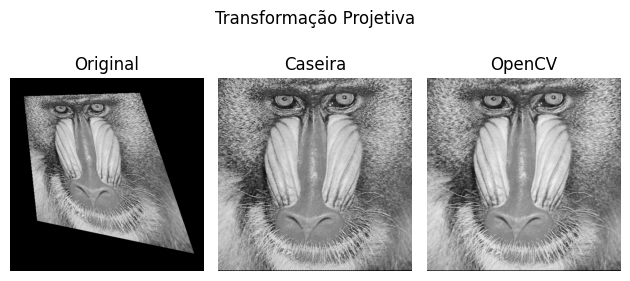

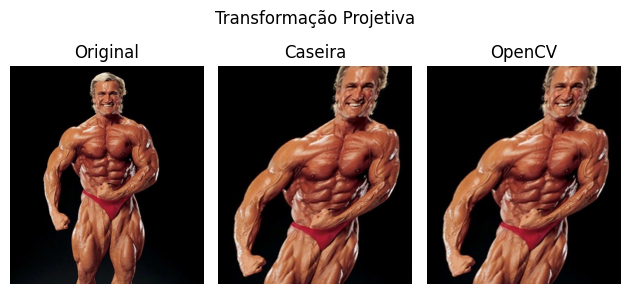

In [448]:
def line_plot(imgs, legend, title):
    
    size = len(imgs)
    
    fig, axs = plt.subplots(1,size, layout='tight')
    fig.suptitle(title, y=.81)

    for i in range(len(imgs)):
        axs[i].imshow(imgs[i], cmap='gray')
        axs[i].set_title(legend[i])
        axs[i].axis('off')

    plt.show()

line_plot([baboon_p, ans, new_b], ['Original', 'Caseira', 'OpenCV'], 'Transformação Projetiva')

tom_p , tom_m = perspectiva(tom, og_points, new_points)

new_tom = cv2.warpPerspective(tom, mt, (tom.shape[1], tom.shape[0]))

line_plot([tom, tom_p, new_tom], ['Original', 'Caseira', 'OpenCV'], 'Transformação Projetiva')

### Diferença entre implementações

Diferenca CV2 e Caseira (15 casas decimais):
[[ 0.0e+00 -0.0e+00  5.7e-14]
 [ 1.0e-15 -1.0e-15  4.3e-14]
 [-0.0e+00 -0.0e+00  0.0e+00]] 
Erro percentual = 1.8173828125%


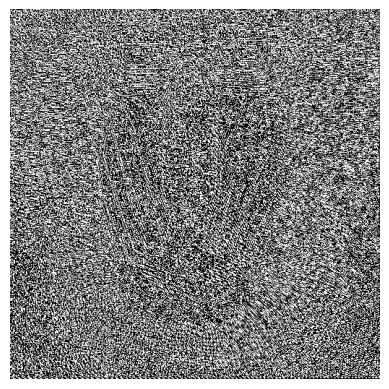

In [449]:
diff = ans - new_b
plt.imshow(diff, cmap='gray')
plt.axis('off')

total_diff_pixels = np.where((diff > 0))

dif_y , dif_x = total_diff_pixels
total_diff = len(dif_y) + len(dif_x)
er = total_diff / (ans.shape[0] * ans.shape[1])

print(f'Diferenca CV2 e Caseira (15 casas decimais):\n{np.round(mt - my_matrix, 15)} ')
print(f'Erro percentual = {er}%')

### Transformações Geométricas
Escreva um programa para realizar as transformacoes geometricas de escala e rotacao em uma imagem. O 
fator de escala e o valor do angulo de rotacao devem permitir valores contınuos (ou seja, valores em ponto
flutuante).

Para completar as imagens utilize:

2.1 Interpolacao pelo Vizinho Mais Proximo

2.2 Interpolacao Bilinear 

2.3 Interpolacao Bicubica

2.4 Interpolacao por Polinomios de Lagrange



In [450]:
def nearest_neighbor(img, x, y, y_f, x_f):

    og_cols = np.floor(x / x_f).astype(np.uint32)
    og_rows = np.floor(y / y_f).astype(np.uint32)

    return img[og_rows, og_cols]


def bilinear(img, x, y, y_f, x_f):

    h, w  = img.shape[:2]
    n_h, n_w = int(h * y_f), int(w * x_f)

    x_og = (x * ((w - 1) / n_w))
    y_og = (y * ((h - 1) / n_h))

    dx = x_og - ((x_og).astype(int))
    dy = y_og - ((y_og).astype(int))

    X = np.clip(x_og.astype(int), 0, w - 2)
    Y = np.clip(y_og.astype(int), 0, h - 2)

    pos = []

    for i in range(2):
        for j in range(2):
            pos.append(np.array([Y + i, X + j]))


    inter = (((1 - dx) * (1 - dy) * pos[0]) + 
            (dx * (1 - dy) * pos[1]) + 
            (dy * (1 - dx) * pos[2]) + 
            (dx * dy * pos[3])).astype(int)

    return img[inter[0], inter[1]]

def r_foo(x):   
    a = np.maximum(0, x)
    return (1/6) * ((a + 2)**3 - 4 * (a + 1)**3 + 6 * (a)**3 - 4 * (a - 1)**3)  


def bicubica(img, x, y, y_f, x_f):

    ans = np.ones_like(x, dtype='float64')

    X = np.floor(x / x_f).astype(int)
    Y = np.floor(y / y_f).astype(int)

    X = np.clip(X, 1, img.shape[1] - 3)
    Y = np.clip(Y, 1, img.shape[0] - 3)

    dx = (x / x_f).astype(int) - X
    dy = (y / y_f).astype(int) - Y 

    pos = []
    for m in range(-1, 3):
        for n in range(-1, 3):
            ans += img[Y+n, X+m] * r_foo(m - dx) * r_foo(dy - n)

    return ans

def l_foo(n, dx, f, x , y):

    a = (1/6) * -dx * (dx - 1) * (dx - 2) * f[y - 1, x + n - 2]
    b = (1/2) * (dx + 1) * (dx - 1) * (dx - 2) * f[y, x + n - 2]
    c = (1/2) * -dx * (dx + 1) * (dx - 2) * f[y + 1, x + n - 2]
    d = (1/6) * dx * (dx + 1) * (dx - 1) * f[y + 2, x + n - 2]
        
    return a + b + c + d

def lagrange(img, x, y, y_f, x_f):

    X = np.floor(x / x_f).astype(int)
    Y = np.floor(y / y_f).astype(int)

    X = np.clip(X, 1, img.shape[1] - 3)
    Y = np.clip(Y, 1, img.shape[0] - 3)

    dx = (x / x_f).astype(int) - X
    dy = (y / y_f).astype(int) - Y 

    L = [l_foo(i, dx, img, X, Y) for i in range(1,5)]

    inx = np.array((
        (1/6) * -dy * (dy - 1) * (dy - 2 ) * L[0] +
        (1/2) * (dy + 1) * (dy - 1 ) * (dy - 2) * L[1] + 
        (1/2) * -dy * (dy + 1) * ( dy - 2) * L[2] +
        (1/6) * dy * (dy + 1) * (dy - 1) * L[3]
    ).astype(int))

    return inx


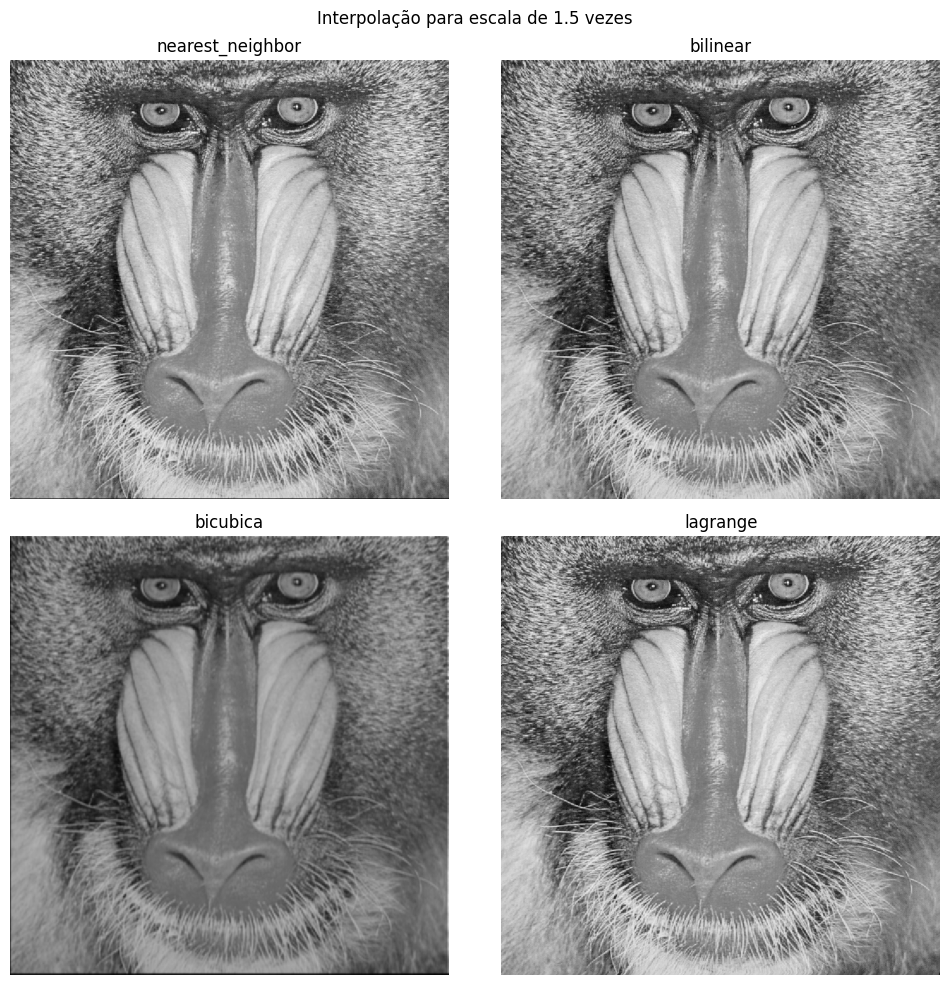

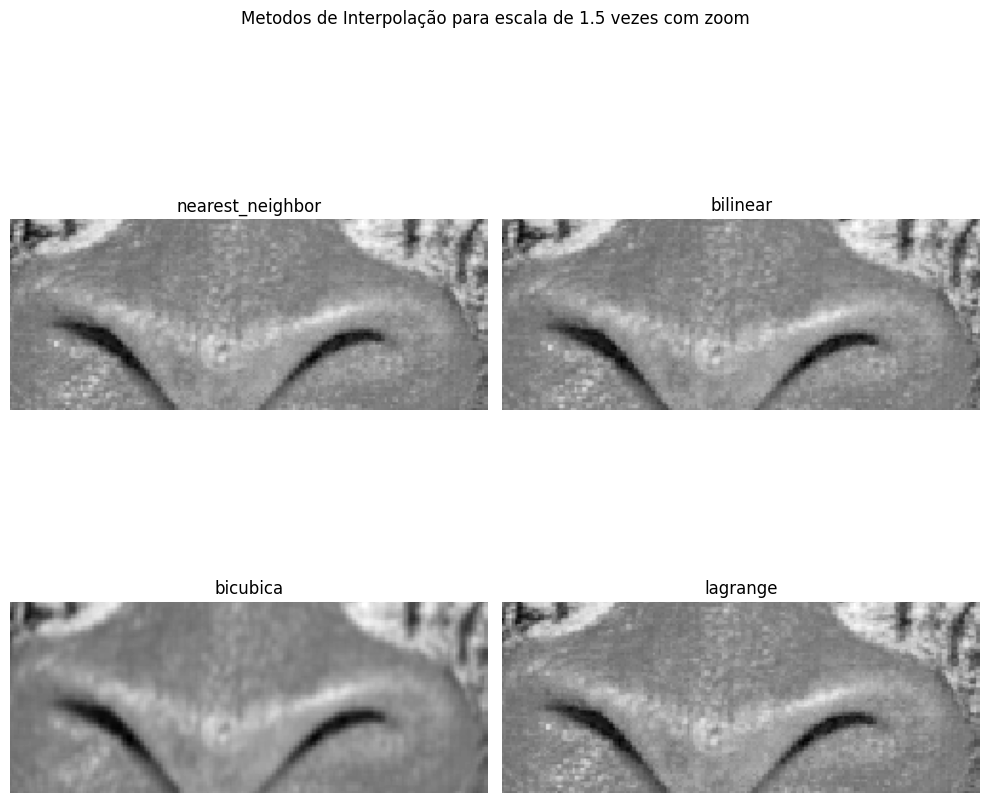

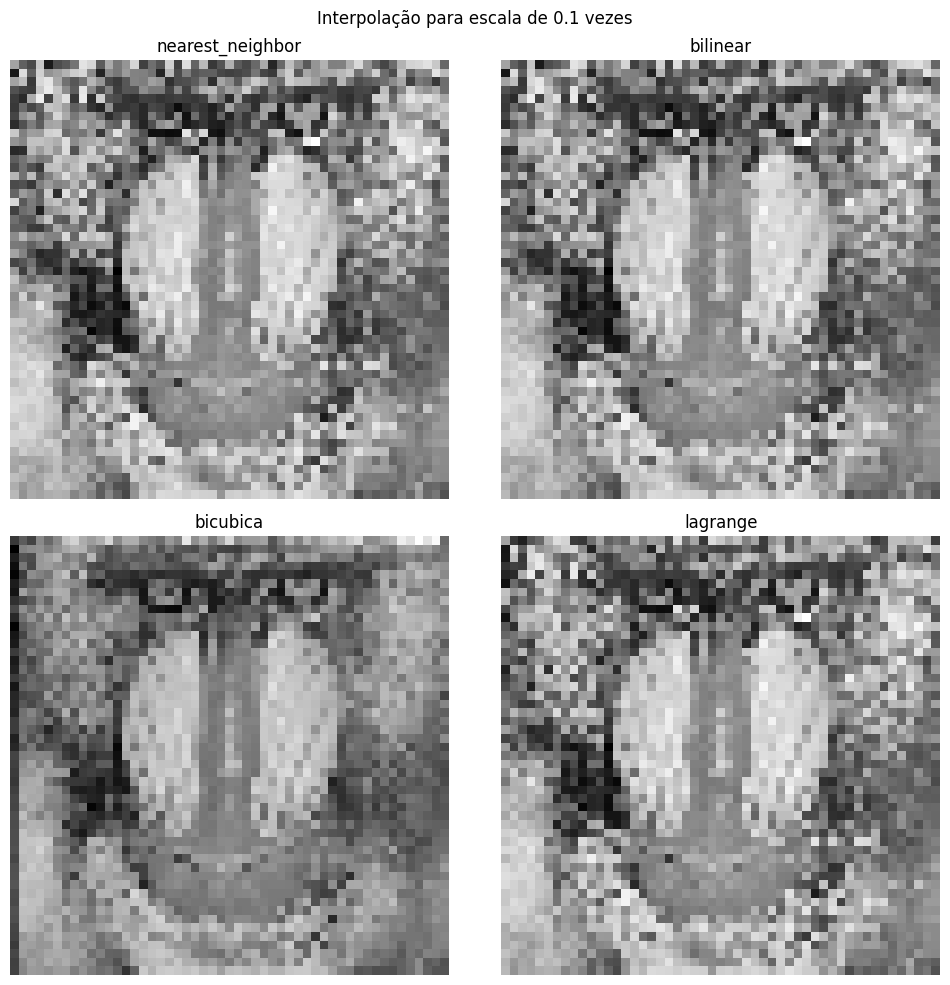

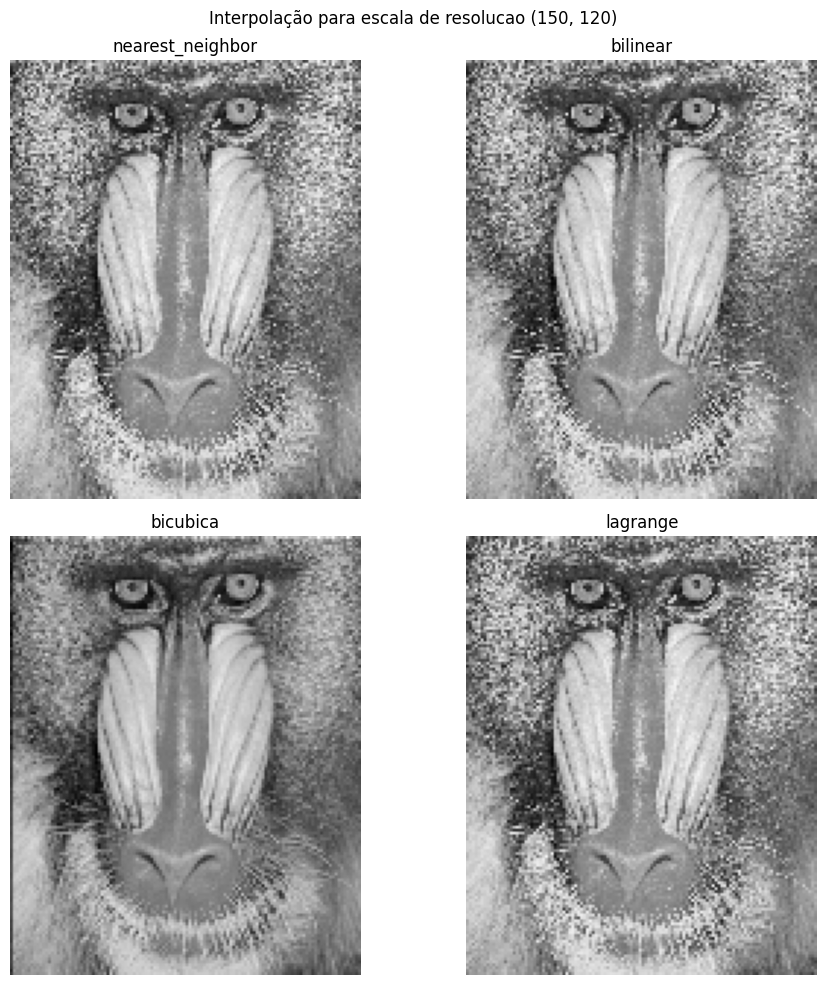

In [451]:
def scale_img(img, factor, inter_foo=nearest_neighbor):
    
    h, w  = img.shape[:2] 

    values = {tuple : np.divide(factor, img.shape)}

    y_f , x_f = values.get(type(factor), (factor, factor))

    scaled = np.zeros((int(h * y_f), int(w * x_f)))
    n_rows , n_cols = np.indices(scaled.shape) # y, x 

    if len(img.shape) == 3:
        
        r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

        slices = [r,g,b]

        n_rows , n_cols = np.indices(scaled.shape)

        nR, nG, nB = [inter_foo(img, n_cols, n_rows, y_f, x_f) for img in slices]

        return cv2.merge((nR,nG,nB))

    ans = inter_foo(img, n_cols, n_rows, y_f, x_f)
    return ans

def rotate_img(img, ang):

    y, x = np.indices(img.shape[:2])

    x = x - img.shape[1] / 2
    y = y - img.shape[0] / 2

    r = np.deg2rad(ang)

    X = np.cos(r) * x + np.sin(r) * y
    Y = -np.sin(r) * x + np.cos(r) * y

    X = X + img.shape[1] / 2
    Y = Y + img.shape[0] / 2 

    if len(img.shape) == 2:
        img = np.pad(img, 1)

    X = np.clip(X, 0, img.shape[1] - 1).astype(int)
    Y = np.clip(Y, 0, img.shape[0] - 1).astype(int)

    return img[Y,X]

def interp_plot(imgs, f, title, cut=None):

    fig, ax = plt.subplots(2,2, figsize=(10,10))
    fig.suptitle(title)
    if cut == None:
        for i in range(2):
            for j in range(2):
                ax[i,j].imshow(imgs[i*2 + j], cmap='gray')
                ax[i,j].set_title(labels[i*2+j])
                ax[i,j].axis('off')
    else:
        
        y1, y2 , x1, x2 = cut

        for i in range(2):
            for j in range(2):
                ax[i,j].imshow(imgs[i*2 + j, y1:y2, x1:x2], cmap='gray')
                ax[i,j].set_title(labels[i*2+j])
                ax[i,j].axis('off')
        
    fig.tight_layout()

    plt.show()

in_img = babs
f = 1.5
scales = [nearest_neighbor, bilinear, bicubica, lagrange]
labels = ['nearest_neighbor', 'bilinear', 'bicubica', 'lagrange']
cut = [500,600, 250,500]

imgs = np.array([ scale_img(in_img, f, scales[i]) for i in range(4)])

interp_plot(imgs, f, f'Interpolação para escala de {f} vezes')

interp_plot(imgs, f, f'Metodos de Interpolação para escala de {f} vezes com zoom', cut = cut)

f = .1
imgs = np.array([ scale_img(in_img, f, scales[i]) for i in range(4)])

interp_plot(imgs, .1, f'Interpolação para escala de {f} vezes')

f = (150, 120)
imgs = np.array([ scale_img(in_img, f, scales[i]) for i in range(4)])

interp_plot(imgs, f, f'Interpolação para escala de resolucao {f}')

### Imagens coloridas

In [452]:
# testes com o fisiculturista  ( 3 canais RGB )
f = 1.88
t = scale_img(tom, f, nearest_neighbor)
t1 = scale_img(tom, f, bilinear)
t2 = scale_img(tom, f, bicubica)
t3 = scale_img(tom, f, lagrange)
t = (t - np.min(t)) / (np.max(t) - np.min(t))
t1 = (t1 - np.min(t1)) / (np.max(t1) - np.min(t1))
t2 = (t2 - np.min(t2)) / (np.max(t2) - np.min(t2))
t3 = (t3 - np.min(t3)) / (np.max(t3) - np.min(t3))
tomk = np.array([t, t1, t2, t3])


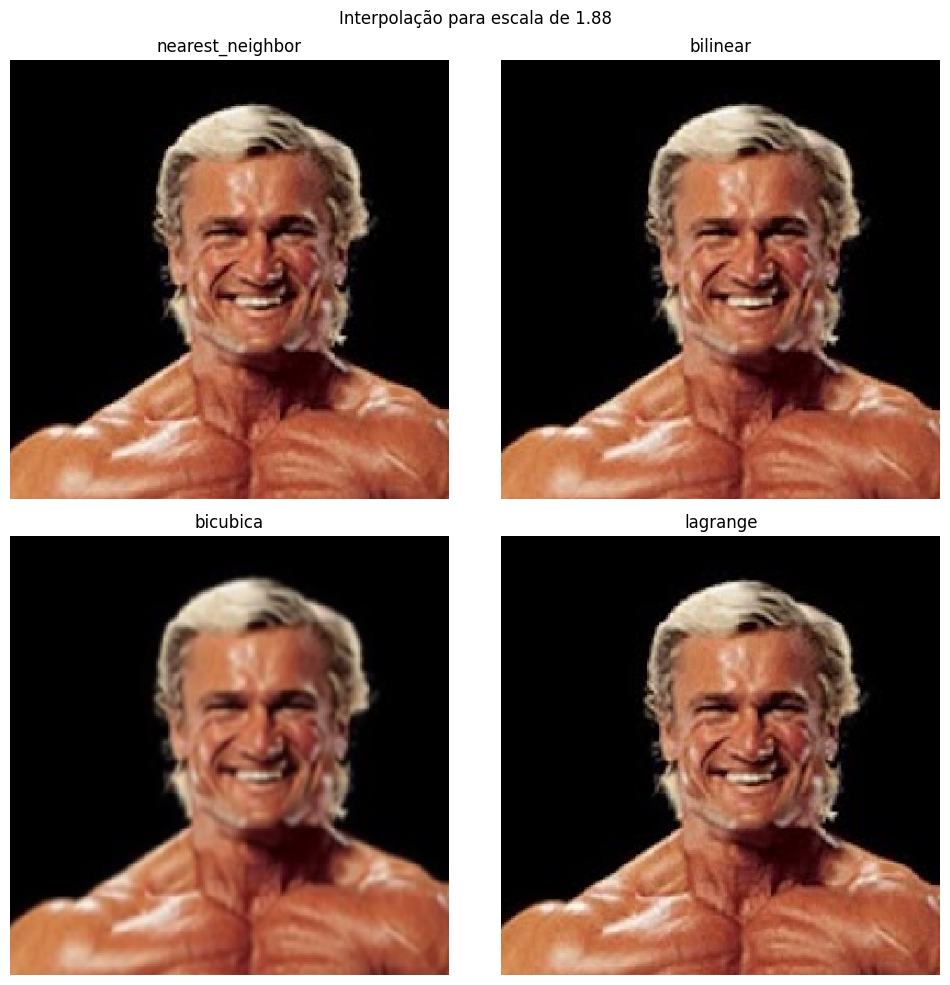

In [453]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
fig.suptitle(f'Interpolação para escala de {f}')
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(tomk[i*2 + j, :400, 300:700])#, 0:int(100*f),int(90*f):int(180*f)])
        ax[i,j].set_title(labels[i*2+j])
        ax[i,j].axis('off')
        ax[i,j].set_title(labels[i*2+j])
fig.tight_layout()

## Aplicando rotações

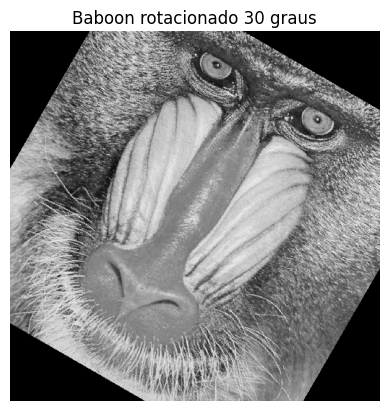

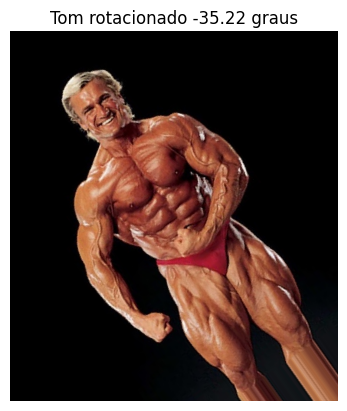

In [454]:
plt.title('Baboon rotacionado 30 graus')
plt.imshow(rotate_img(babs, 30), cmap='gray')
plt.axis('off')
plt.show()

t_r = -35.22
plt.title(f'Tom rotacionado {t_r} graus')
plt.axis('off')
plt.imshow(rotate_img(tom, t_r), cmap='gray')
plt.show()